In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Fairness Audit Report  
## AI Resume Screening System  
### Role: Data Scientist

---

## 1. Executive Summary

### This report audits the fairness of an AI-assisted resume screening system for the Data Scientist role.  
### The analysis focuses on experience-level differences in hiring outcomes and evaluates whether observed disparities persist after controlling for AI screening scores.


In [3]:
df = pd.read_csv('/Users/mr.tian/Desktop/AI_Resume_Screening.csv')

In [5]:
df.head()

,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


In [8]:
df.shape

(1000, 11)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Resume_ID               1000 non-null   int64 
 1   Name                    1000 non-null   object
 2   Skills                  1000 non-null   object
 3   Experience (Years)      1000 non-null   int64 
 4   Education               1000 non-null   object
 5   Certifications          726 non-null    object
 6   Job Role                1000 non-null   object
 7   Recruiter Decision      1000 non-null   object
 8   Salary Expectation ($)  1000 non-null   int64 
 9   Projects Count          1000 non-null   int64 
 10  AI Score (0-100)        1000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [13]:
df.isna().sum()

Resume_ID                   0
Name                        0
Skills                      0
Experience (Years)          0
Education                   0
Certifications            274
Job Role                    0
Recruiter Decision          0
Salary Expectation ($)      0
Projects Count              0
AI Score (0-100)            0
dtype: int64

In [19]:
df['Job Role'].value_counts()

Job Role
AI Researcher            257
Data Scientist           255
Cybersecurity Analyst    255
Software Engineer        233
Name: count, dtype: int64

In [47]:
role = 'Data Scientist'
df_role = df[df['Job Role'] == role].copy()

In [25]:
df_role['Recruiter Decision'].value_counts(normalize=True)

Recruiter Decision
Hire      0.803922
Reject    0.196078
Name: proportion, dtype: float64

In [27]:
df_role['AI Score (0-100)'].describe()

count    255.000000
mean      83.843137
std       20.116171
min       20.000000
25%       70.000000
50%       95.000000
75%      100.000000
max      100.000000
Name: AI Score (0-100), dtype: float64

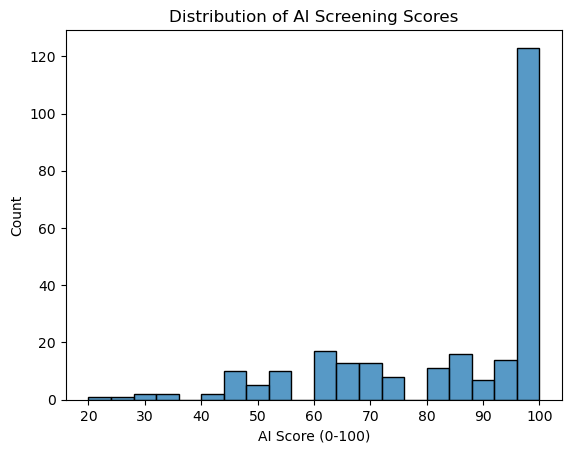

In [31]:
sns.histplot(df_role['AI Score (0-100)'], bins=20)
plt.title("Distribution of AI Screening Scores")
plt.show()

In [35]:
df_role.groupby('Recruiter Decision')['AI Score (0-100)'].mean()

Recruiter Decision
Hire      91.97561
Reject    50.50000
Name: AI Score (0-100), dtype: float64

In [49]:
def exp_bucket(x):
    if x < 3:
        return "Junior"
    elif x < 7:
        return "Mid"
    else:
        return "Senior"

df_role['Experience Level'] = df_role['Experience (Years)'].apply(exp_bucket)

In [41]:
hire_rate_by_exp = (
    df_role
    .groupby('Experience Level')['Recruiter Decision']
    .apply(lambda x: (x == 'Hire').mean())
)

hire_rate_by_exp

Experience Level
Junior    0.40
Mid       0.92
Senior    1.00
Name: Recruiter Decision, dtype: float64

In [45]:
df_role.groupby('Experience Level')['AI Score (0-100)'].mean()

Experience Level
Junior    59.214286
Mid       87.850000
Senior    99.411765
Name: AI Score (0-100), dtype: float64

## 2. Exploratory Data Analysis (EDA)
## The following analysis explores the distribution of AI screening scores and recruiter decisions across experience levels.


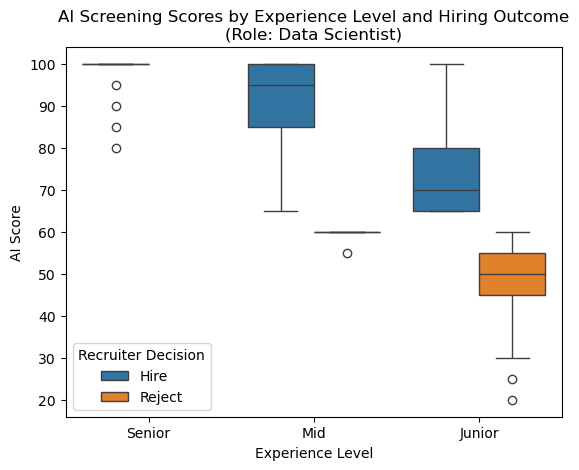

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=df_role,
    x='Experience Level',
    y='AI Score (0-100)',
    hue='Recruiter Decision'
)

plt.title(
    f"AI Screening Scores by Experience Level and Hiring Outcome\n(Role: {role})"
)
plt.xlabel("Experience Level")
plt.ylabel("AI Score")
plt.show()

## 3. Fairness Metrics

## This section reports selection rates, demographic parity difference, and disparate impact across experience levels.


In [57]:
df_fair = df_role.copy()
df_fair['y'] = (df_fair['Recruiter Decision'] == 'Hire').astype(int)

In [59]:
selection_rate = (
    df_fair
    .groupby('Experience Level')['y']
    .mean()
    .sort_values(ascending=False)
)

selection_rate

Experience Level
Senior    1.00
Mid       0.92
Junior    0.40
Name: y, dtype: float64

In [61]:
baseline_group = 'Mid'
baseline_rate = selection_rate.loc[baseline_group]
baseline_rate

0.92

In [63]:
dp_diff = selection_rate - baseline_rate
dp_diff

Experience Level
Senior    0.08
Mid       0.00
Junior   -0.52
Name: y, dtype: float64

In [65]:
disparate_impact = selection_rate / baseline_rate
disparate_impact

Experience Level
Senior    1.086957
Mid       1.000000
Junior    0.434783
Name: y, dtype: float64

In [67]:
audit_table = (
    pd.DataFrame({
        'Selection Rate': selection_rate,
        'DP Difference': dp_diff,
        'Disparate Impact': disparate_impact
    })
    .round(3)
)

audit_table

,Selection Rate,DP Difference,Disparate Impact
Experience Level,,,
Senior,1.00,0.08,1.087
Mid,0.92,0.00,1.000
Junior,0.40,-0.52,0.435


## 4. Conditional Fairness Analysis
## To distinguish score-driven disparities from conditional unfairness...


In [71]:
bins = [0, 50, 70, 85, 100]
labels = ['Low', 'Medium', 'High', 'Very High']

df_cf = df_fair.copy()
df_cf['score_bin'] = pd.cut(
    df_cf['AI Score (0-100)'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_cf['score_bin'].value_counts().sort_index()

score_bin
Low           23
Medium        53
High          35
Very High    144
Name: count, dtype: int64

In [73]:
cond_sr = (
    df_cf
    .groupby(['score_bin', 'Experience Level'])['y']
    .mean()
    .unstack()
)

cond_sr

/var/folders/_t/99rhfqy12md_q88dy260m5d80000gn/T/ipykernel_68047/2924891491.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['score_bin', 'Experience Level'])['y']


Experience Level,Junior,Mid,Senior
score_bin,,,
Low,0.000000,NaN,NaN
Medium,0.441176,0.578947,NaN
High,1.000000,1.000000,1.0
Very High,1.000000,1.000000,1.0


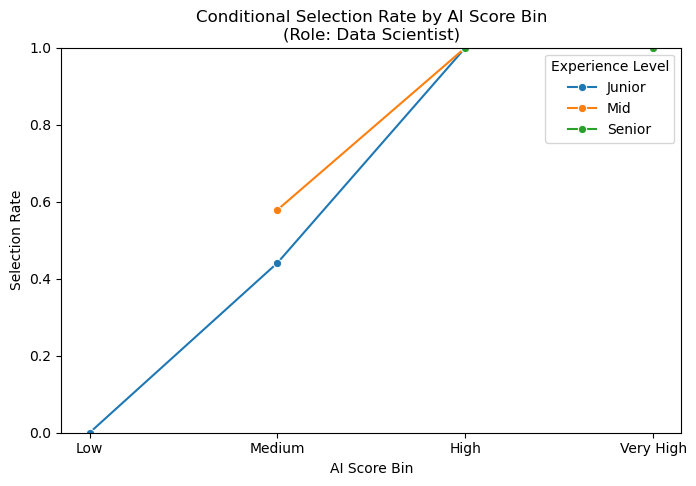

In [75]:
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=cond_sr.reset_index().melt(
        id_vars='score_bin',
        var_name='Experience Level',
        value_name='Selection Rate'
    ),
    x='score_bin',
    y='Selection Rate',
    hue='Experience Level',
    marker='o'
)

plt.title(f"Conditional Selection Rate by AI Score Bin\n(Role: {role})")
plt.xlabel("AI Score Bin")
plt.ylabel("Selection Rate")
plt.ylim(0, 1)
plt.show()
